Ex. 1

1. In the first exercise you will design a simpler variant of LODA. First you
will generate a 2D dataset that follows a standard normal distribution
(500 points) using sklearn.datasets.make blobs.

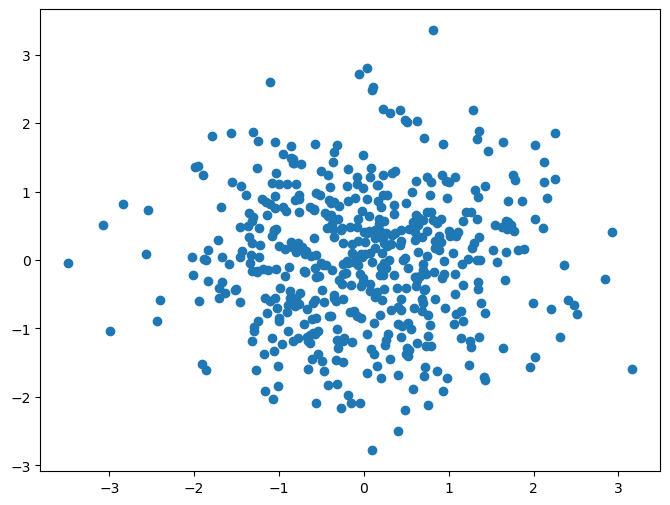

In [2]:
import sklearn.datasets
import matplotlib.pyplot as plt

X, y = sklearn.datasets.make_blobs(n_samples=500, n_features=2, centers=[(0, 0)], cluster_std=1.0)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

2. Then you will randomly generate 5 unit-length projection vectors (you
can use numpy.random.multivariate normal with (0, 0) mean and
identity matrix as covariance matrix) that will be used to generate 1D
histograms (for the projected values). You will compute the corresponding histograms with equal-width bins using numpy.histogram (for the
range parameter use a larger interval than the range of the projected values). For each histogram compute the probability corresponding to each
bin and use them to compute the anomaly score of a sample as the mean
of the probabilities (corresponding to each histogram).

In [3]:
import numpy as np

mean = [0 ,0]
cov = np.eye(2)
projection_vectors = np.random.multivariate_normal(mean, cov, 5)

projected_values = [X @ projection_vectors[i] for i in range(5)]
num_bins = 30  
bin_probabilities = []
histograms = []

for projection in projected_values:
    range_min, range_max = np.min(projection) - 1, np.max(projection) + 1
    hist, bin_edges = np.histogram(projection, bins=num_bins, range=(range_min, range_max), density=True)
    bin_probs = hist / hist.sum()
    bin_probabilities.append(bin_probs)
    histograms.append((hist, bin_edges))
    
anomaly_scores = np.zeros(X.shape[0])
for i, projection in enumerate(projected_values):
    bin_edges = histograms[i][1]
    bin_probs = bin_probabilities[i]
    bin_indices = np.digitize(projection, bin_edges) - 1 
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)  
    sample_probs = bin_probs[bin_indices]
    anomaly_scores += sample_probs
    
print(len(anomaly_scores))

500


3. For testing, generate a dataset with 500 points from a uniform distribution
(between -3 and 3 using np.random.uniform). Plot the points in the
test dataset using a colormap (related to the anomaly scores).

In [4]:
test_data = np.random.uniform(-3, 3, size=(500, 2))
test_anomaly_scores = np.zeros(test_data.shape[0])

for i, projection_vector in enumerate(projection_vectors):
    test_projection = test_data @ projection_vector
    bin_edges = histograms[i][1]
    bin_probs = bin_probabilities[i]
    bin_indices = np.digitize(test_projection, bin_edges) - 1  
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)  
    sample_probs = bin_probs[bin_indices]
    test_anomaly_scores += sample_probs

test_anomaly_scores /= 5
plt.figure(figsize=(8, 6))
scatter = plt.scatter(test_data[:, 0], test_data[:, 1], c=test_anomaly_scores, cmap='viridis', edgecolor='k')
plt.colorbar(scatter, label="Anomaly Score")
plt.title("Test Dataset with Anomaly Scores (Colormap)")
plt.grid(True)
plt.show()

4. Use different number of bins and see how this affects the score map.

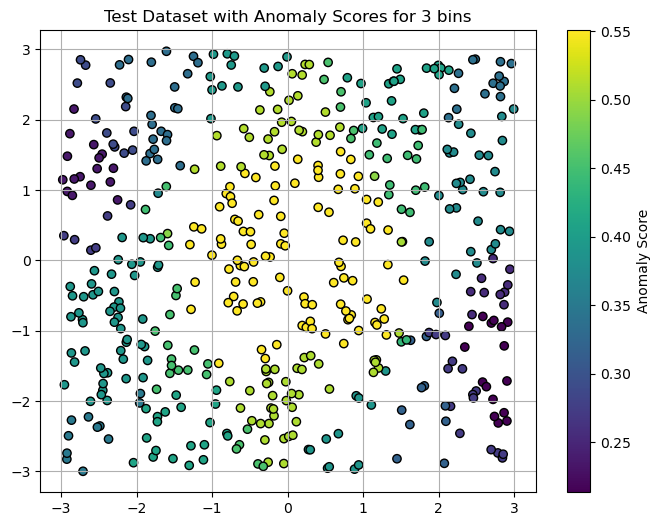

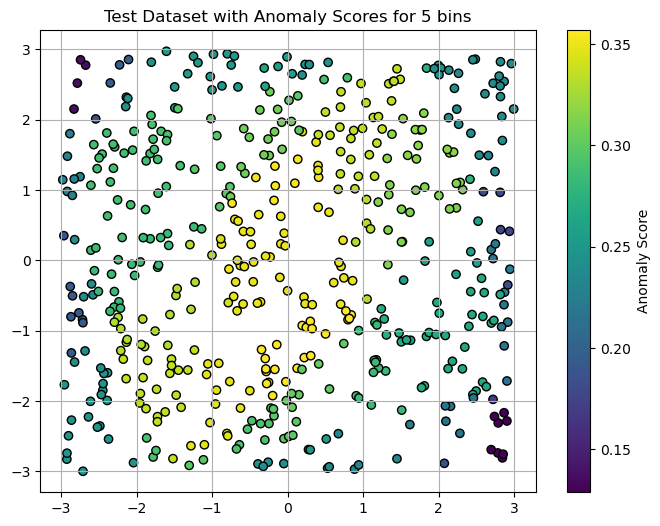

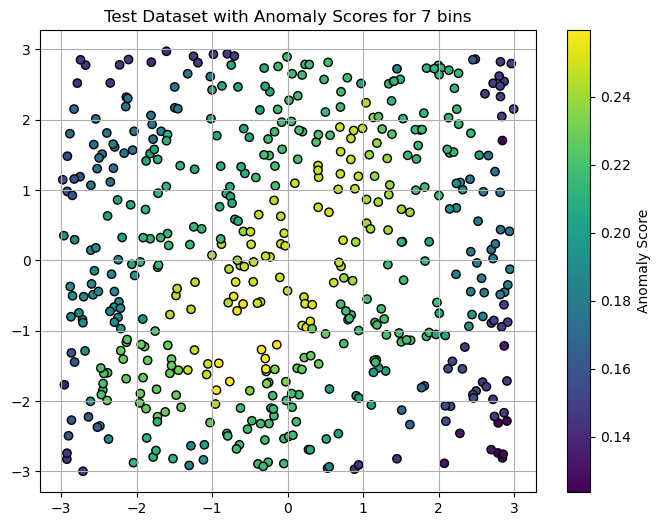

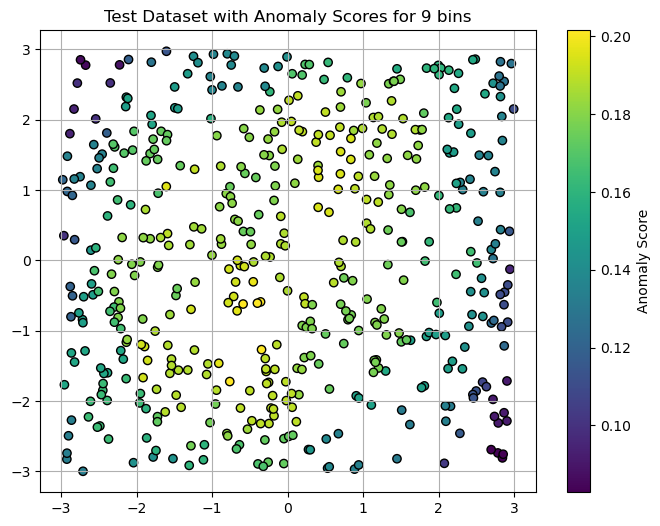

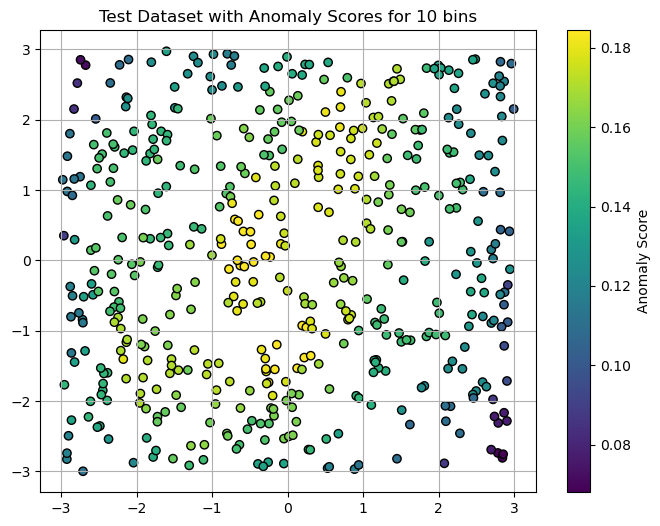

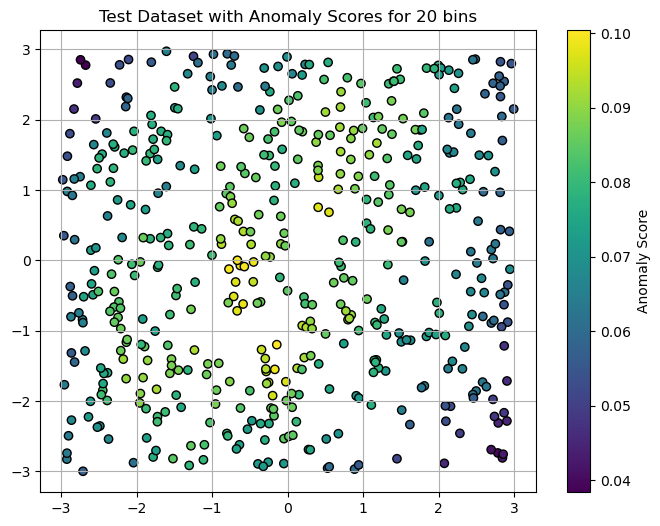

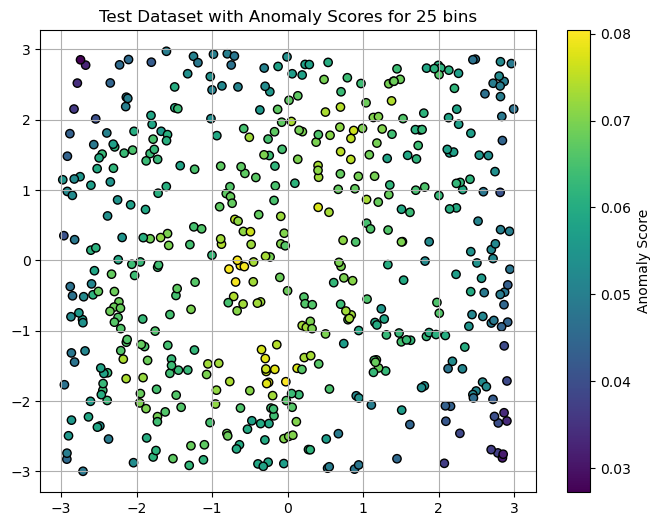

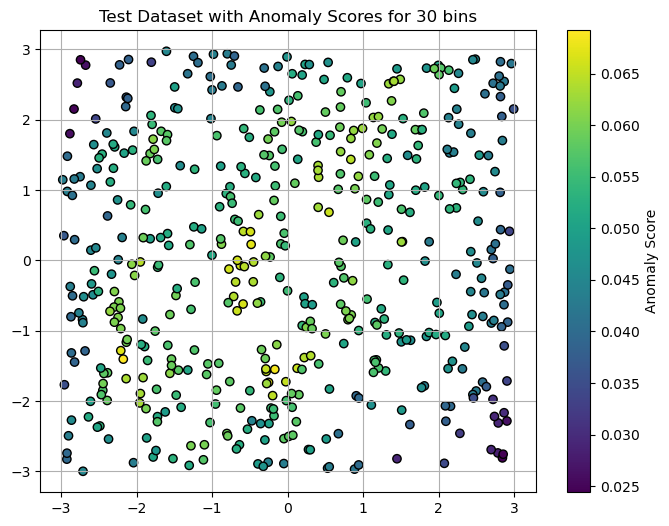

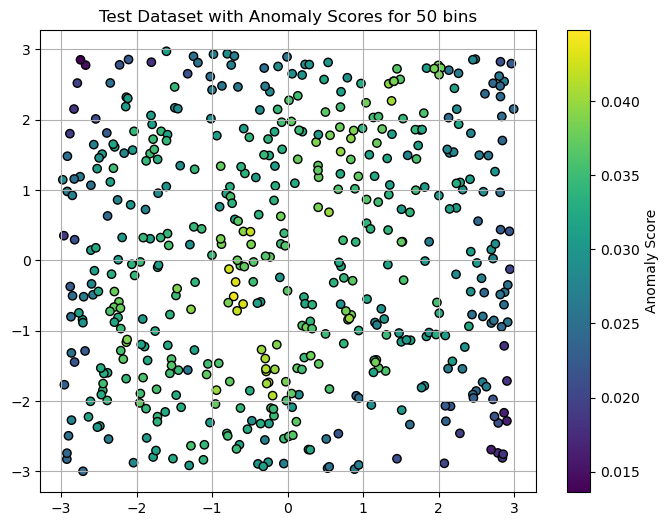

In [5]:
def anomaly_scores_with_histograms(data, projection_vectors, num_bins, num_projections=5):
    projected_values = [data @ projection_vectors[i] for i in range(num_projections)]
    bin_probabilities = []
    histograms = []

    for projection in projected_values:
        range_min, range_max = np.min(projection) - 1, np.max(projection) + 1
        hist, bin_edges = np.histogram(projection, bins=num_bins, range=(range_min, range_max), density=True)
        bin_probs = hist / hist.sum()
        bin_probabilities.append(bin_probs)
        histograms.append((hist, bin_edges))
        
    anomaly_scores = np.zeros(X.shape[0])
    for i, projection in enumerate(projected_values):
        bin_edges = histograms[i][1]
        bin_probs = bin_probabilities[i]
        bin_indices = np.digitize(projection, bin_edges) - 1 
        bin_indices = np.clip(bin_indices, 0, num_bins - 1)  
        sample_probs = bin_probs[bin_indices]
        anomaly_scores += sample_probs
    
    anomaly_scores /= num_projections
    return anomaly_scores

num_bins_list = [3, 5, 7, 9, 10, 15, 20, 25, 30, 50, 100]
for num_bins in num_bins_list:
    anomaly_scores = anomaly_scores_with_histograms(data=test_data, projection_vectors=projection_vectors, num_bins=num_bins)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(test_data[:, 0], test_data[:, 1], c=anomaly_scores, cmap='viridis', edgecolor='k')
    plt.colorbar(scatter, label="Anomaly Score")
    plt.title(f"Test Dataset with Anomaly Scores for {num_bins} bins")
    plt.grid(True)
    plt.show()


Ex. 2

1. In this exercise we will try to see how the standard Isolation Forest algorithm introduces some artifacts when computing the anomaly scores.
You will generate 2 clusters of 2-dimensional data using make blobs()
function. The 2 clusters will have (10, 0) and (0, 10) as centers, 1 as
standard deviation and 500 samples each.

In [6]:
X, y = sklearn.datasets.make_blobs(n_samples=[500, 500], n_features=2, centers=[(10,0), (0, 10)], cluster_std=[1.0, 1.0])

2. You will fit an IForest model (from pyod.models.iforest) using this
data (and a contamination rate of 0.02). Test data will be generated from
a uniform distribution over the interval (-10, 20) using np.random.uniform
and will contain 1000 samples.

In [7]:
from pyod.models.iforest import IForest

contamination_rate=0.02
clf = IForest(contamination=contamination_rate)
clf.fit(X)
y_train_pred = clf.labels_ 
y_train_scores = clf.decision_scores_ 

test_data = np.random.uniform(-10, 20, size=(1000, 2))


3. Find the anomaly scores for the test data and plot the samples using a colormap (related to the anomaly scores). Observe the artefacts introduced
by the axis-parallel separating hyperplanes used by standard IForest.

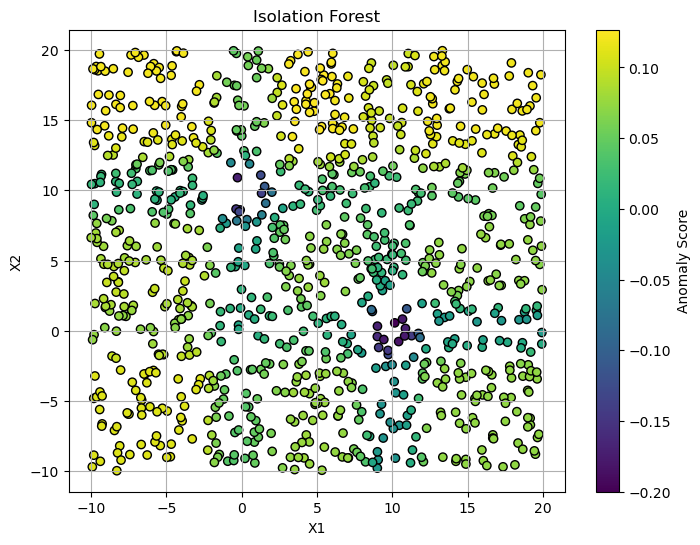

In [8]:
test_scores_iforest = clf.decision_function(test_data) 

plt.figure(figsize=(8, 6))
scatter_iforest = plt.scatter(test_data[:, 0], test_data[:, 1], c=test_scores_iforest, cmap='viridis', edgecolor='k')
plt.colorbar(scatter_iforest, label="Anomaly Score")
plt.title("Isolation Forest")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()

4. Repeat the same procedure for Deep Isolation Forest model (DIF from
pyod.models.dif ) and LODA (from pyod.models.loda) and use 3 subplots for the 3 figures.

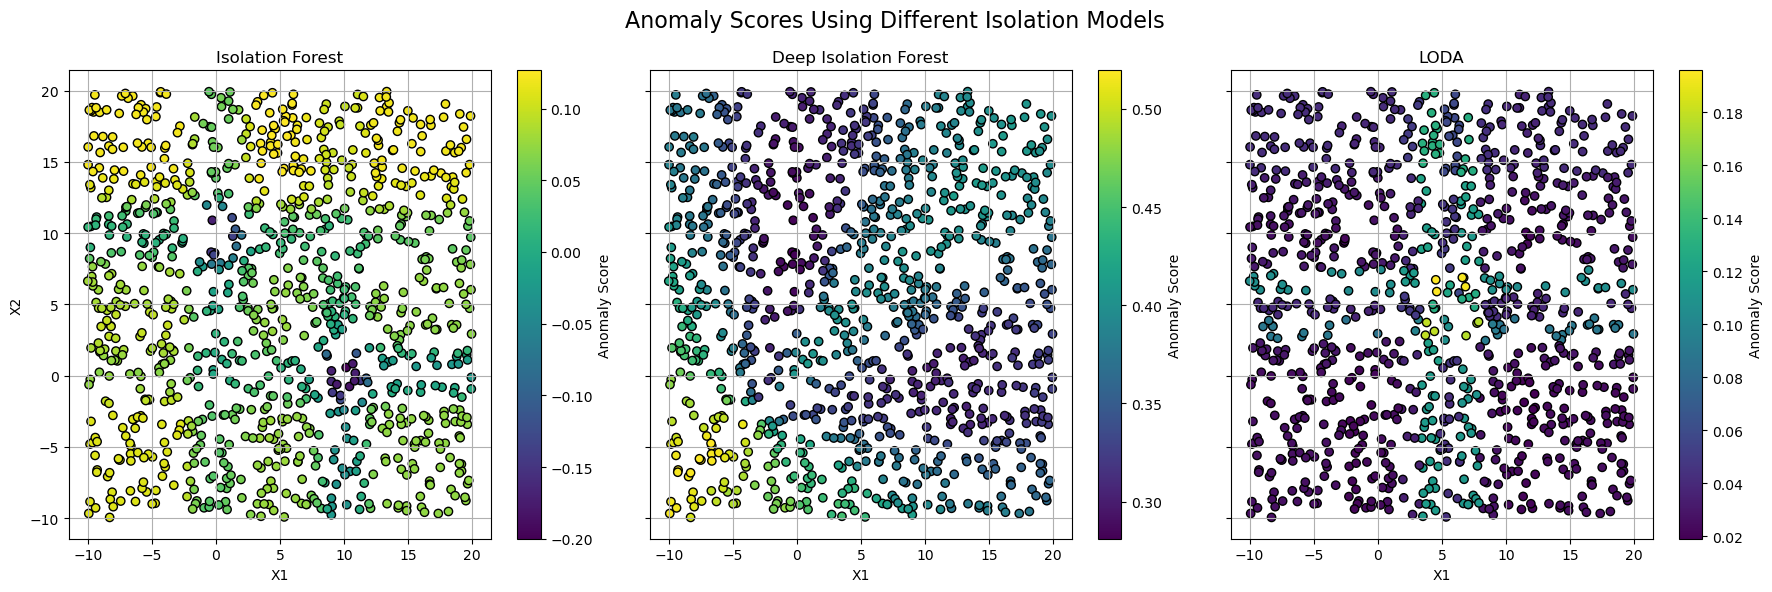

In [11]:
from pyod.models.dif import DIF
from pyod.models.loda import LODA

clf = DIF(contamination=contamination_rate)
clf.fit(X)
y_train_pred = clf.labels_ 
y_train_scores = clf.decision_scores_ 
test_scores_dif = clf.decision_function(test_data) 

clf = LODA(contamination=contamination_rate)
clf.fit(X)
y_train_pred = clf.labels_ 
y_train_scores = clf.decision_scores_ 
test_scores_loda = clf.decision_function(test_data) 

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
scatter_iforest = axes[0].scatter(test_data[:, 0], test_data[:, 1], c=test_scores_iforest, cmap='viridis', edgecolor='k')
axes[0].set_title("Isolation Forest")
axes[0].set_xlabel("X1")
axes[0].set_ylabel("X2")
plt.colorbar(scatter_iforest, ax=axes[0], label="Anomaly Score")
axes[0].grid(True)

scatter_dif = axes[1].scatter(test_data[:, 0], test_data[:, 1], c=test_scores_dif, cmap='viridis', edgecolor='k')
axes[1].set_title("Deep Isolation Forest")
axes[1].set_xlabel("X1")
plt.colorbar(scatter_dif, ax=axes[1], label="Anomaly Score")
axes[1].grid(True)


scatter_loda = axes[2].scatter(test_data[:, 0], test_data[:, 1], c=test_scores_loda, cmap='viridis', edgecolor='k')
axes[2].set_title("LODA")
axes[2].set_xlabel("X1")
plt.colorbar(scatter_loda, ax=axes[2], label="Anomaly Score")
axes[2].grid(True)

plt.suptitle("Anomaly Scores Using Different Isolation Models", fontsize=16)
plt.tight_layout()  
plt.show()


5. Try different number of neurons for the hidden layers used by DIF and
different number of bins for LODA. Try to explain why the score maps
for LODA look that way.

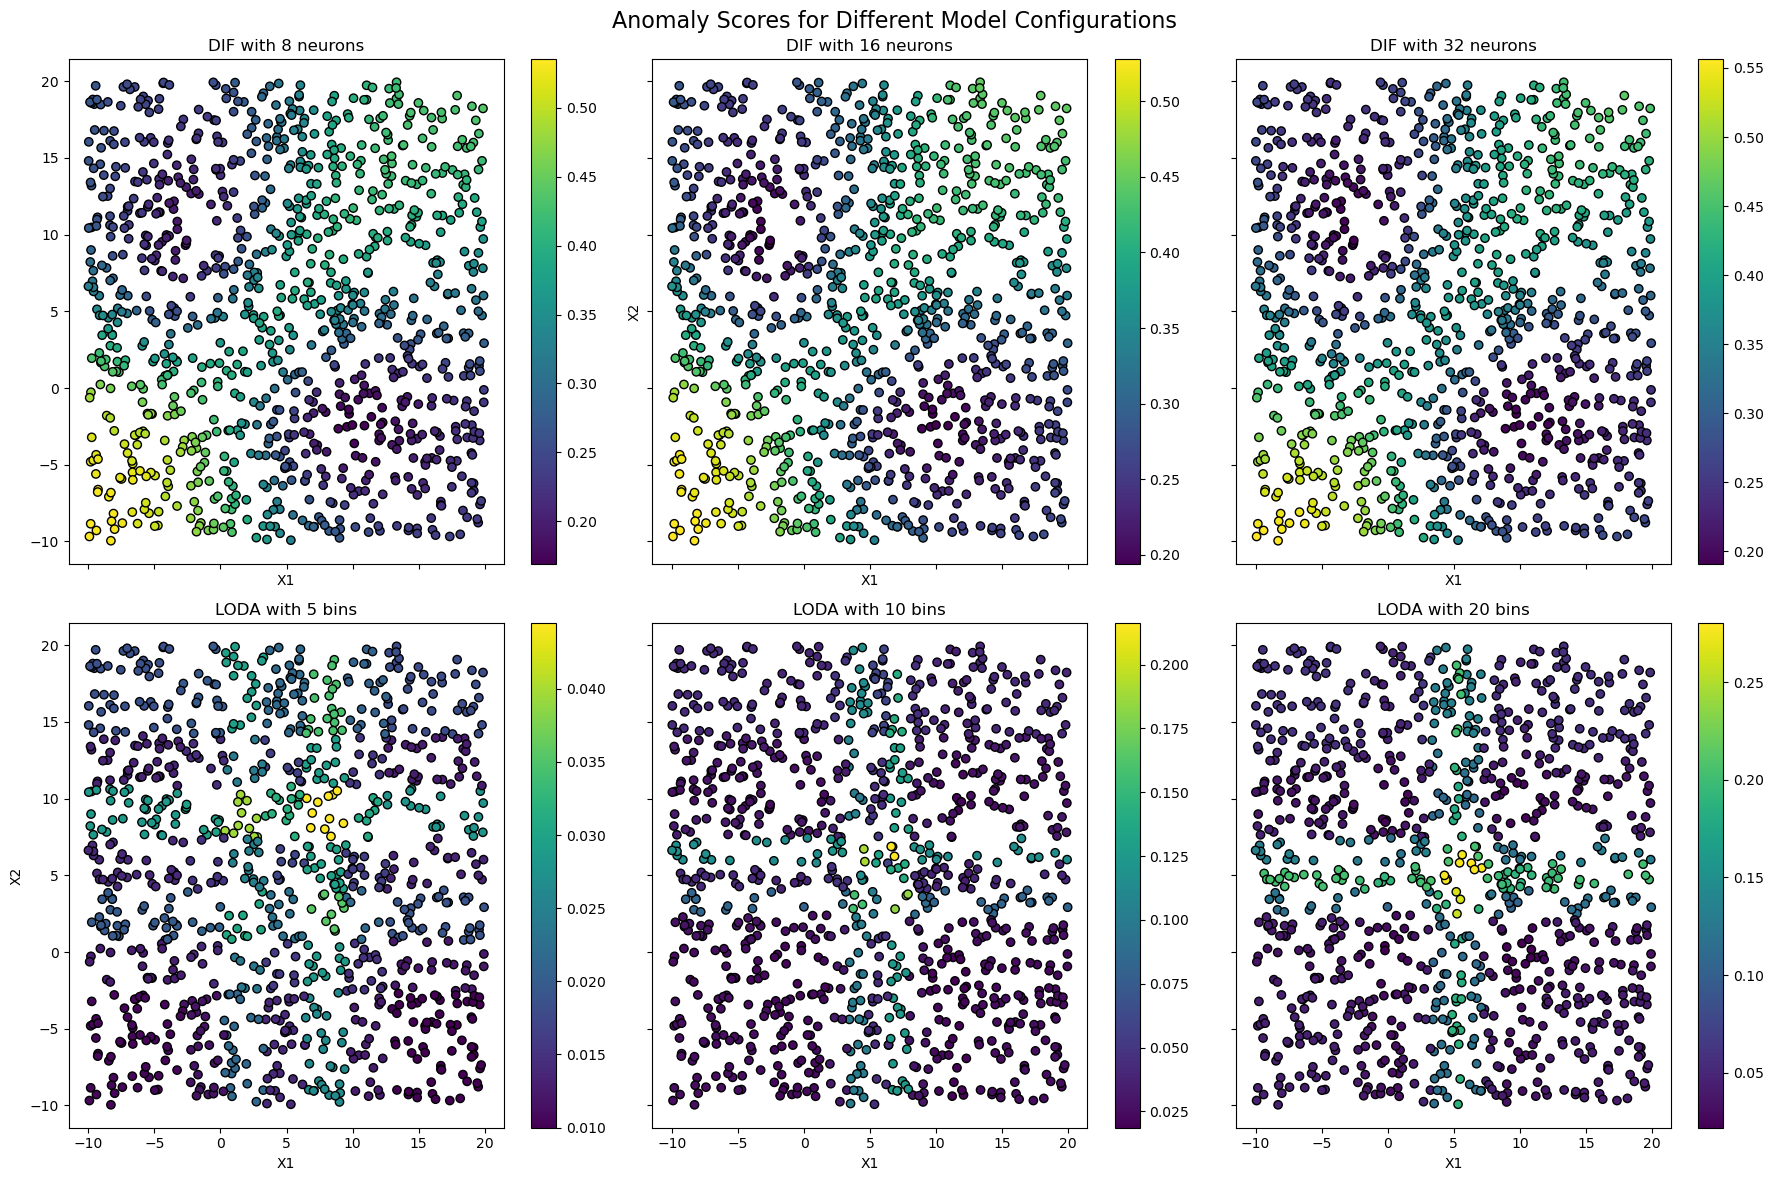

In [13]:
dif_neurons_configs = [8, 16, 32]  
loda_bins_configs = [5, 10, 20]    

fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)

for i, neurons in enumerate(dif_neurons_configs, start=0):
    clf_dif = DIF(hidden_neurons=[neurons], contamination=contamination_rate)
    clf_dif.fit(X)
    test_scores_dif = clf_dif.decision_function(test_data)
    
    scatter_dif = axes[0, i].scatter(test_data[:, 0], test_data[:, 1], c=test_scores_dif, cmap='viridis', edgecolor='k')
    axes[0, i].set_title(f"DIF with {neurons} neurons")
    axes[0, i].set_xlabel("X1")
    if i == 1:
        axes[0, i].set_ylabel("X2")
    fig.colorbar(scatter_dif, ax=axes[0, i])

for i, bins in enumerate(loda_bins_configs):
    clf_loda = LODA(n_bins=bins, contamination=contamination_rate)
    clf_loda.fit(X)
    test_scores_loda = clf_loda.decision_function(test_data)
    
    scatter_loda = axes[1, i].scatter(test_data[:, 0], test_data[:, 1], c=test_scores_loda, cmap='viridis', edgecolor='k')
    axes[1, i].set_title(f"LODA with {bins} bins")
    axes[1, i].set_xlabel("X1")
    if i == 0:
        axes[1, i].set_ylabel("X2")
    fig.colorbar(scatter_loda, ax=axes[1, i])

plt.suptitle("Anomaly Scores for Different Model Configurations", fontsize=16)
plt.tight_layout()
plt.show()

6. Redo all the steps in 3D (use (0, 10, 0) and (10, 0 , 10) as centers for
the two clusters).

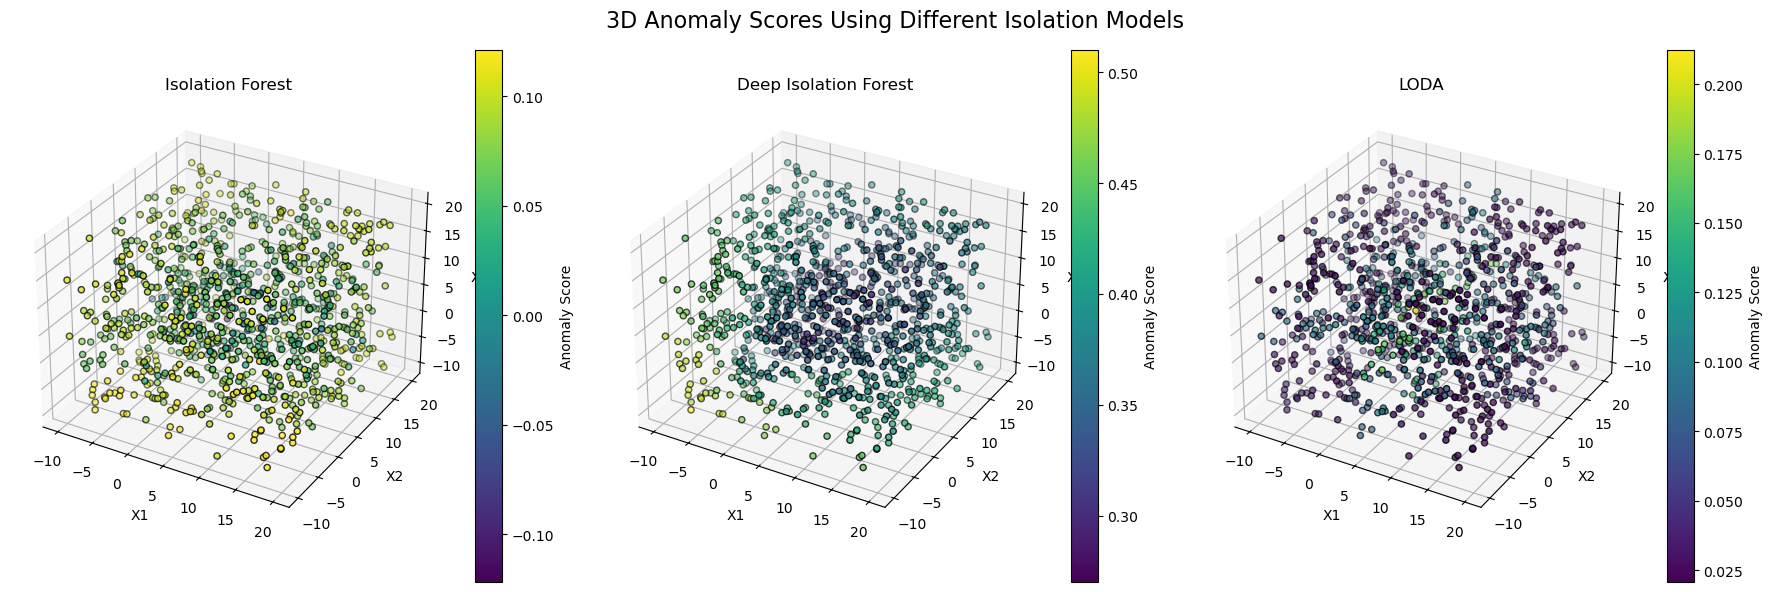

In [ ]:
X, y = sklearn.datasets.make_blobs(n_samples=[500, 500], n_features=3, centers=[(0, 10, 0), (10, 0, 10)], cluster_std=[1.0, 1.0])
contamination_rate = 0.02
test_data = np.random.uniform(-10, 20, size=(1000, 3))

clf_iforest = IForest(contamination=contamination_rate)
clf_iforest.fit(X)
test_scores_iforest = clf_iforest.decision_function(test_data)

clf_dif = DIF(contamination=contamination_rate)
clf_dif.fit(X)
test_scores_dif = clf_dif.decision_function(test_data)

clf_loda = LODA(contamination=contamination_rate)
clf_loda.fit(X)
test_scores_loda = clf_loda.decision_function(test_data)

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
scatter_iforest = ax1.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2], c=test_scores_iforest, cmap='viridis', edgecolor='k')
ax1.set_title("Isolation Forest")
ax1.set_xlabel("X1")
ax1.set_ylabel("X2")
ax1.set_zlabel("X3")
fig.colorbar(scatter_iforest, ax=ax1, label="Anomaly Score")

ax2 = fig.add_subplot(132, projection='3d')
scatter_dif = ax2.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2], c=test_scores_dif, cmap='viridis', edgecolor='k')
ax2.set_title("Deep Isolation Forest")
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_zlabel("X3")
fig.colorbar(scatter_dif, ax=ax2, label="Anomaly Score")

ax3 = fig.add_subplot(133, projection='3d')
scatter_loda = ax3.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2], c=test_scores_loda, cmap='viridis', edgecolor='k')
ax3.set_title("LODA")
ax3.set_xlabel("X1")
ax3.set_ylabel("X2")
ax3.set_zlabel("X3")
fig.colorbar(scatter_loda, ax=ax3, label="Anomaly Score")

plt.suptitle("3D Anomaly Scores Using Different Isolation Models", fontsize=16)
plt.tight_layout()
plt.show()


Ex. 3

1. For this exercise we will need the shuttle dataset from ODDS (https://odds.cs.stonybrook.edu/shuttle-dataset/). Load the data using
scipy.io.loadmat() and use train test split() to split it into train and
test subsets (use 40% of data for testing). Normalize your data accord-
ingly.

In [17]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = loadmat("./shuttle.mat")
X = data['X'] 
y = data['y'].ravel() 

2. Fit IForest, LODA and DIF using the training data and compute the
balanced accuracy (BA) and the area under the curve (ROC AUC -
using sklearn.metrics.roc auc score) for each model. Compute the
mean BA and ROC AUC obtained for 10 different train-test splits for
each of the models.

In [19]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

ba_iforest, ba_dif, ba_loda = [], [], []
roc_auc_iforest, roc_auc_dif, roc_auc_loda = [], [], []

for i in range(10):
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=i)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf_iforest = IForest(contamination=0.02)
    clf_iforest.fit(X_train)
    y_test_pred_iforest = clf_iforest.predict(X_test)
    y_test_scores_iforest = clf_iforest.decision_function(X_test)
    ba_iforest.append(balanced_accuracy_score(y_test, y_test_pred_iforest))
    roc_auc_iforest.append(roc_auc_score(y_test, y_test_scores_iforest))
    print("Balanced Accuracy IForest: ", ba_iforest[-1] )
    
    clf_dif = DIF(contamination=0.02)
    clf_dif.fit(X_train)
    y_test_pred_dif = clf_dif.predict(X_test)
    y_test_scores_dif = clf_dif.decision_function(X_test)
    ba_dif.append(balanced_accuracy_score(y_test, y_test_pred_dif))
    roc_auc_dif.append(roc_auc_score(y_test, y_test_scores_dif))
    print("Balanced Accuracy DIF: ", ba_dif[-1] )

    clf_loda = LODA(contamination=0.02)
    clf_loda.fit(X_train)
    y_test_pred_loda = clf_loda.predict(X_test)
    y_test_scores_loda = clf_loda.decision_function(X_test)
    ba_loda.append(balanced_accuracy_score(y_test, y_test_pred_loda))
    roc_auc_loda.append(roc_auc_score(y_test, y_test_scores_loda))
    print("Balanced Accuracy LODA: ", ba_loda[-1] )


mean_ba_iforest = np.mean(ba_iforest)
mean_roc_auc_iforest = np.mean(roc_auc_iforest)

mean_ba_dif = np.mean(ba_dif)
mean_roc_auc_dif = np.mean(roc_auc_dif)

mean_ba_loda = np.mean(ba_loda)
mean_roc_auc_loda = np.mean(roc_auc_loda)

print(f"Isolation Forest - Mean Balanced Accuracy: {mean_ba_iforest:.4f}, Mean ROC AUC: {mean_roc_auc_iforest:.4f}")
print(f"DIF - Mean Balanced Accuracy: {mean_ba_dif:.4f}, Mean ROC AUC: {mean_roc_auc_dif:.4f}")
print(f"LODA - Mean Balanced Accuracy: {mean_ba_loda:.4f}, Mean ROC AUC: {mean_roc_auc_loda:.4f}")

0
Balanced Accuracy IForest:  0.6317716981977686
Balanced Accuracy DIF:  0.5030282153852165
Balanced Accuracy LODA:  0.6425913497947021
1
Balanced Accuracy IForest:  0.6403147320502733
Balanced Accuracy DIF:  0.5012294939456794
Balanced Accuracy LODA:  0.49166071011456847
2
Balanced Accuracy IForest:  0.6368469867153066
Balanced Accuracy DIF:  0.5022897780804543
Balanced Accuracy LODA:  0.4935269761745449
3
Balanced Accuracy IForest:  0.6540353862532027
Balanced Accuracy DIF:  0.50186868806889
Balanced Accuracy LODA:  0.6192327061979741
4
Balanced Accuracy IForest:  0.6347764656354002
Balanced Accuracy DIF:  0.5015585087475218
Balanced Accuracy LODA:  0.49297189635285227
5
Balanced Accuracy IForest:  0.6310997815003642
Balanced Accuracy DIF:  0.5010924981791697
Balanced Accuracy LODA:  0.4911726314592425
6
Balanced Accuracy IForest:  0.6185349039955566
Balanced Accuracy DIF:  0.5027119038635354
Balanced Accuracy LODA:  0.6344508658328236
7
Balanced Accuracy IForest:  0.6497134670487106